(arima_garch_1_1)=
# Time Series Models Derived From a Generative Graph

:::{post} March, 2024
:tags: time-series, 
:category: intermediate, reference
:author: Juan Orduz and Ricardo Vieira
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt

from pymc.pytensorf import collect_default_updates

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

rng = np.random.default_rng(42)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
lags = 2
trials = 100


def ar_dist(ar_init, rho, sigma, size):
    def ar_step(x_tm2, x_tm1, rho, sigma):
        mu = x_tm1 * rho[0] + x_tm2 * rho[1]
        x = mu + pm.Normal.dist(sigma=sigma)
        return x, collect_default_updates([x])

    ar_innov, _ = pytensor.scan(
        fn=ar_step,
        outputs_info=[{"initial": ar_init, "taps": range(-lags, 0)}],
        non_sequences=[rho, sigma],
        n_steps=trials - lags,
        strict=True,
    )

    return ar_innov

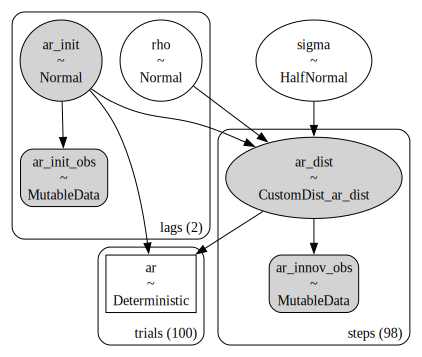

In [3]:
coords = {
    "lags": range(-lags, 0),
    "steps": range(trials - lags),
    "trials": range(trials),
}
with pm.Model(coords=coords, check_bounds=False) as model:
    rho = pm.Normal(name="rho", mu=0, sigma=0.2, dims=("lags",))
    sigma = pm.HalfNormal(name="sigma", sigma=0.2)

    ar_init_obs = pm.MutableData(name="ar_init_obs", value=np.zeros(lags), dims=("lags",))
    ar_init = pm.Normal(name="ar_init", observed=ar_init_obs, dims=("lags",))

    ar_innov_obs = pm.MutableData("ar_innov_obs", np.zeros(trials - lags), dims=("steps",))
    ar_innov = pm.CustomDist(
        "ar_dist",
        ar_init,
        rho,
        sigma,
        dist=ar_dist,
        observed=ar_innov_obs,
        dims=("steps",),
    )

    ar = pm.Deterministic(
        name="ar", var=pt.concatenate([ar_init, ar_innov], axis=-1), dims=("trials",)
    )


pm.model_to_graphviz(model)

## Prior

In [4]:
with model:
    prior = pm.sample_prior_predictive(samples=100, random_seed=rng)

Sampling: [ar_dist, ar_init, rho, sigma]


Text(0.5, 1.0, 'AR(2) Prior Samples')

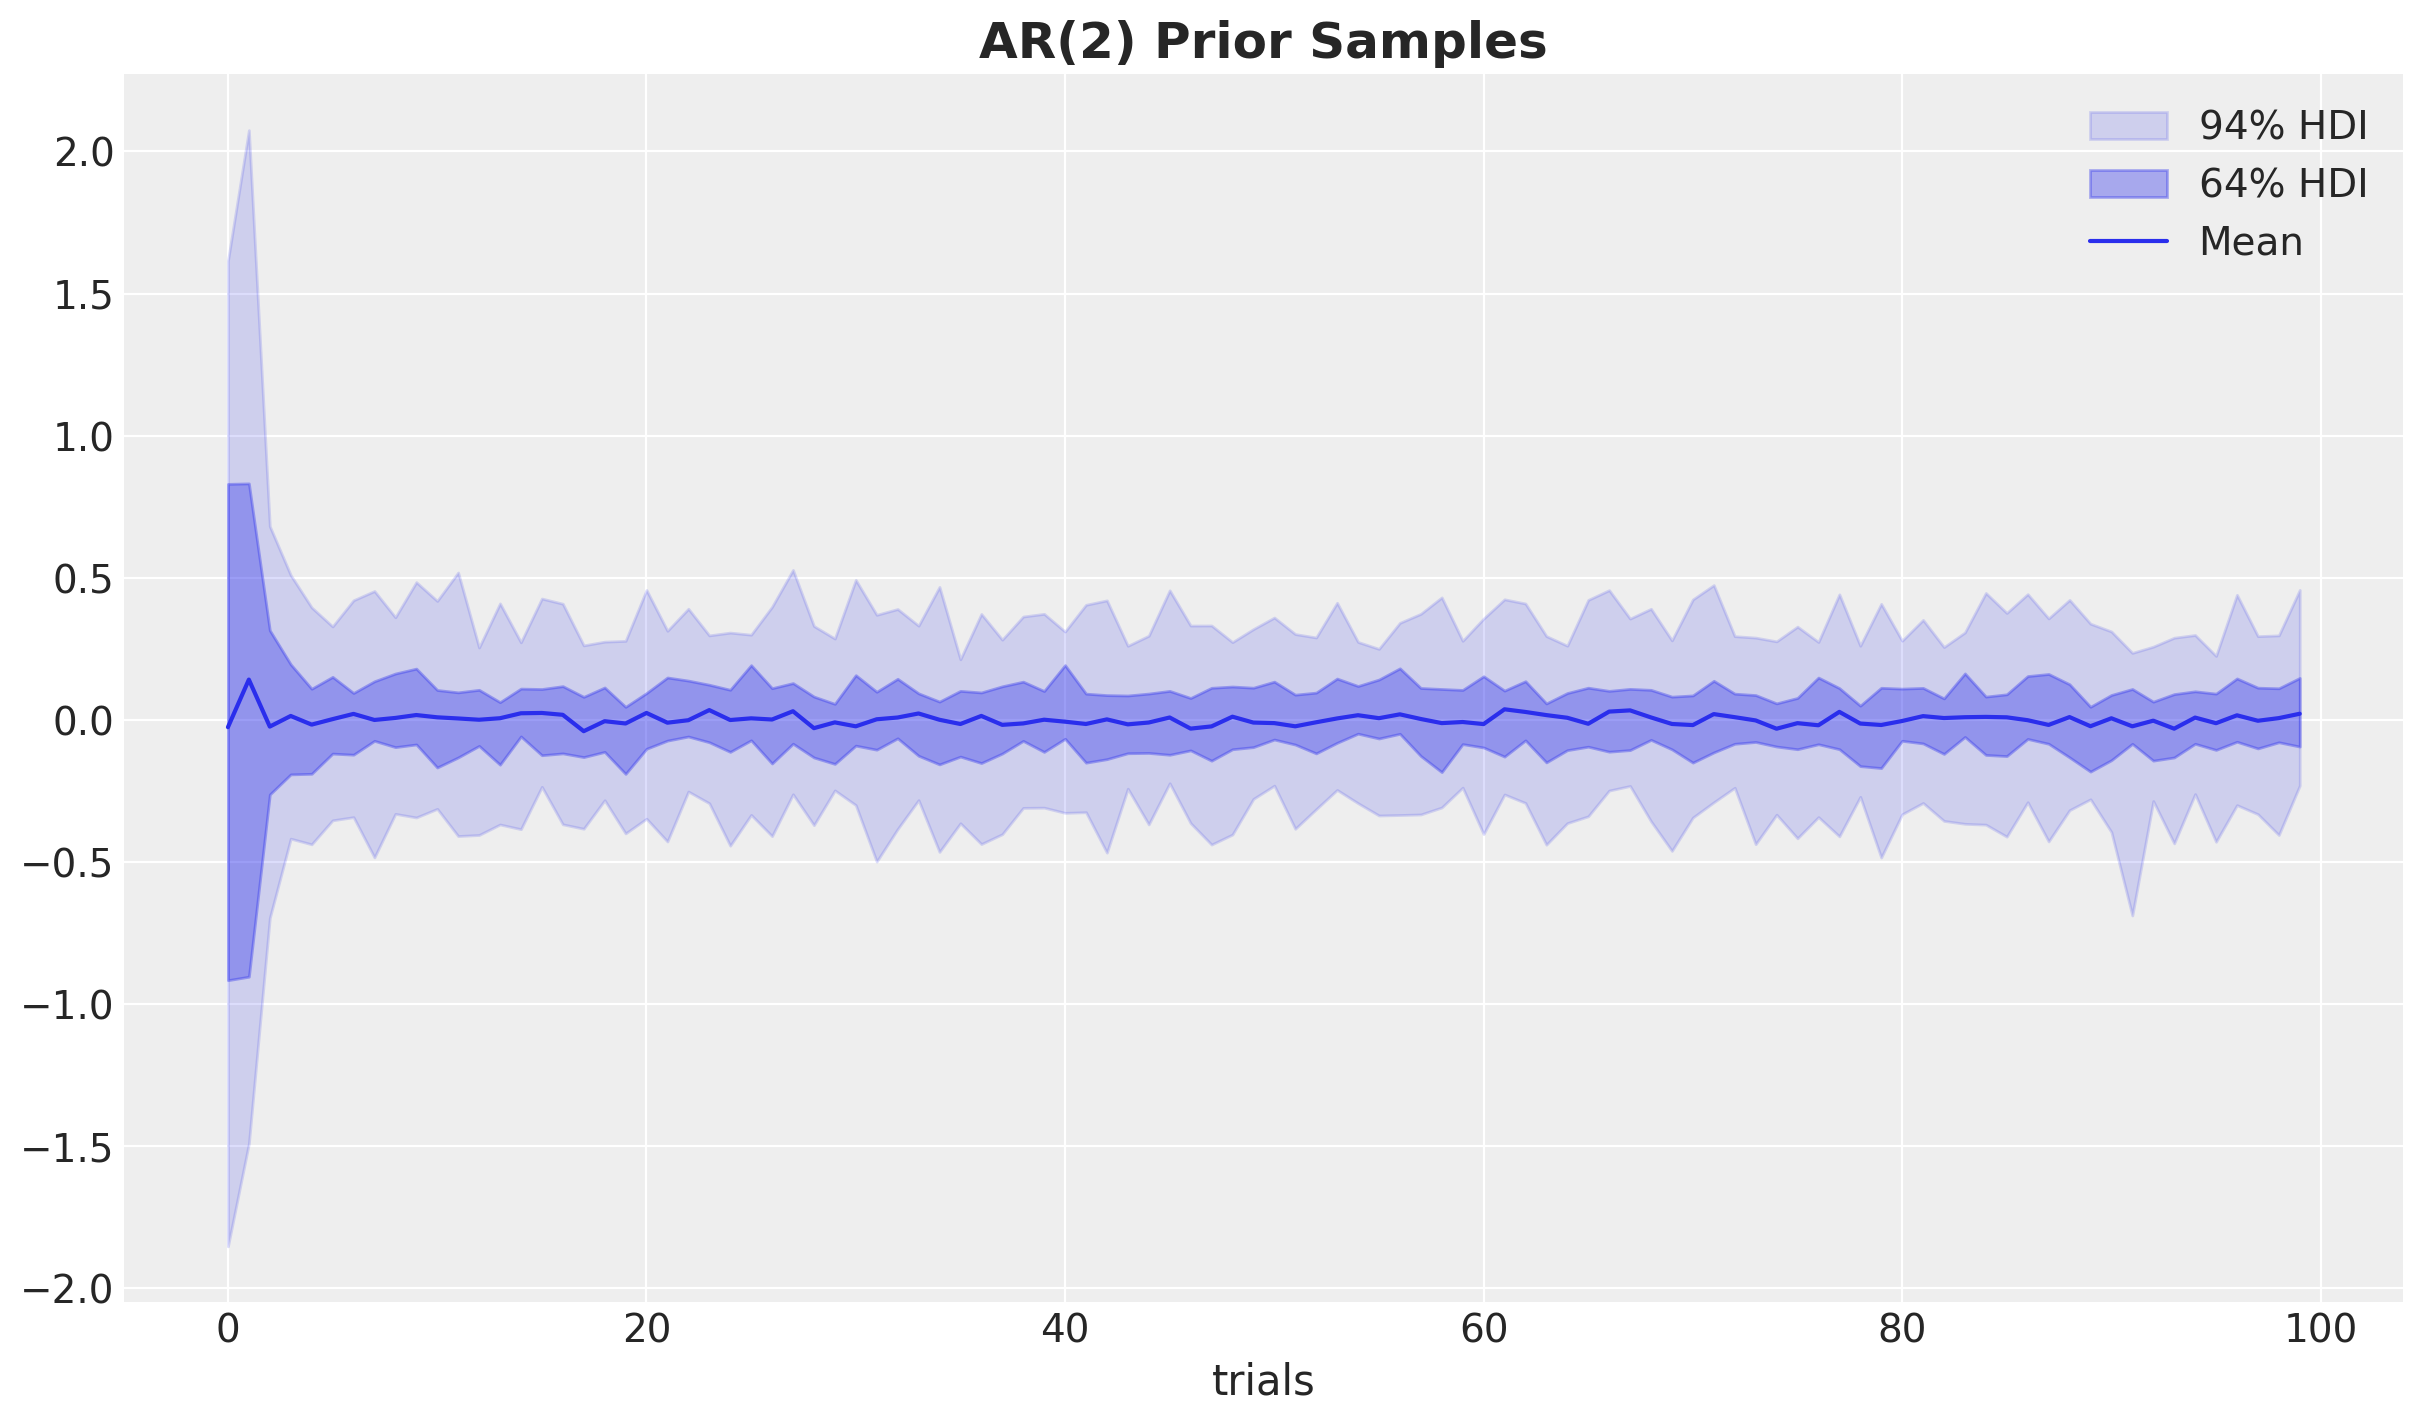

In [5]:
_, ax = plt.subplots()
for i, hdi_prob in enumerate((0.94, 0.64), 1):
    hdi = az.hdi(prior.prior["ar"], hdi_prob=hdi_prob)["ar"]
    lower = hdi.sel(hdi="lower")
    upper = hdi.sel(hdi="higher")
    ax.fill_between(
        x=np.arange(trials),
        y1=lower,
        y2=upper,
        alpha=(i - 0.2) * 0.2,
        color="C0",
        label=f"{hdi_prob:.0%} HDI",
    )
ax.plot(prior.prior["ar"].mean(("chain", "draw")), color="C0", label="Mean")
ax.legend(loc="upper right")
ax.set_xlabel("trials")
ax.set_title("AR(2) Prior Samples", fontsize=18, fontweight="bold")

Text(0.5, 0, 'trials')

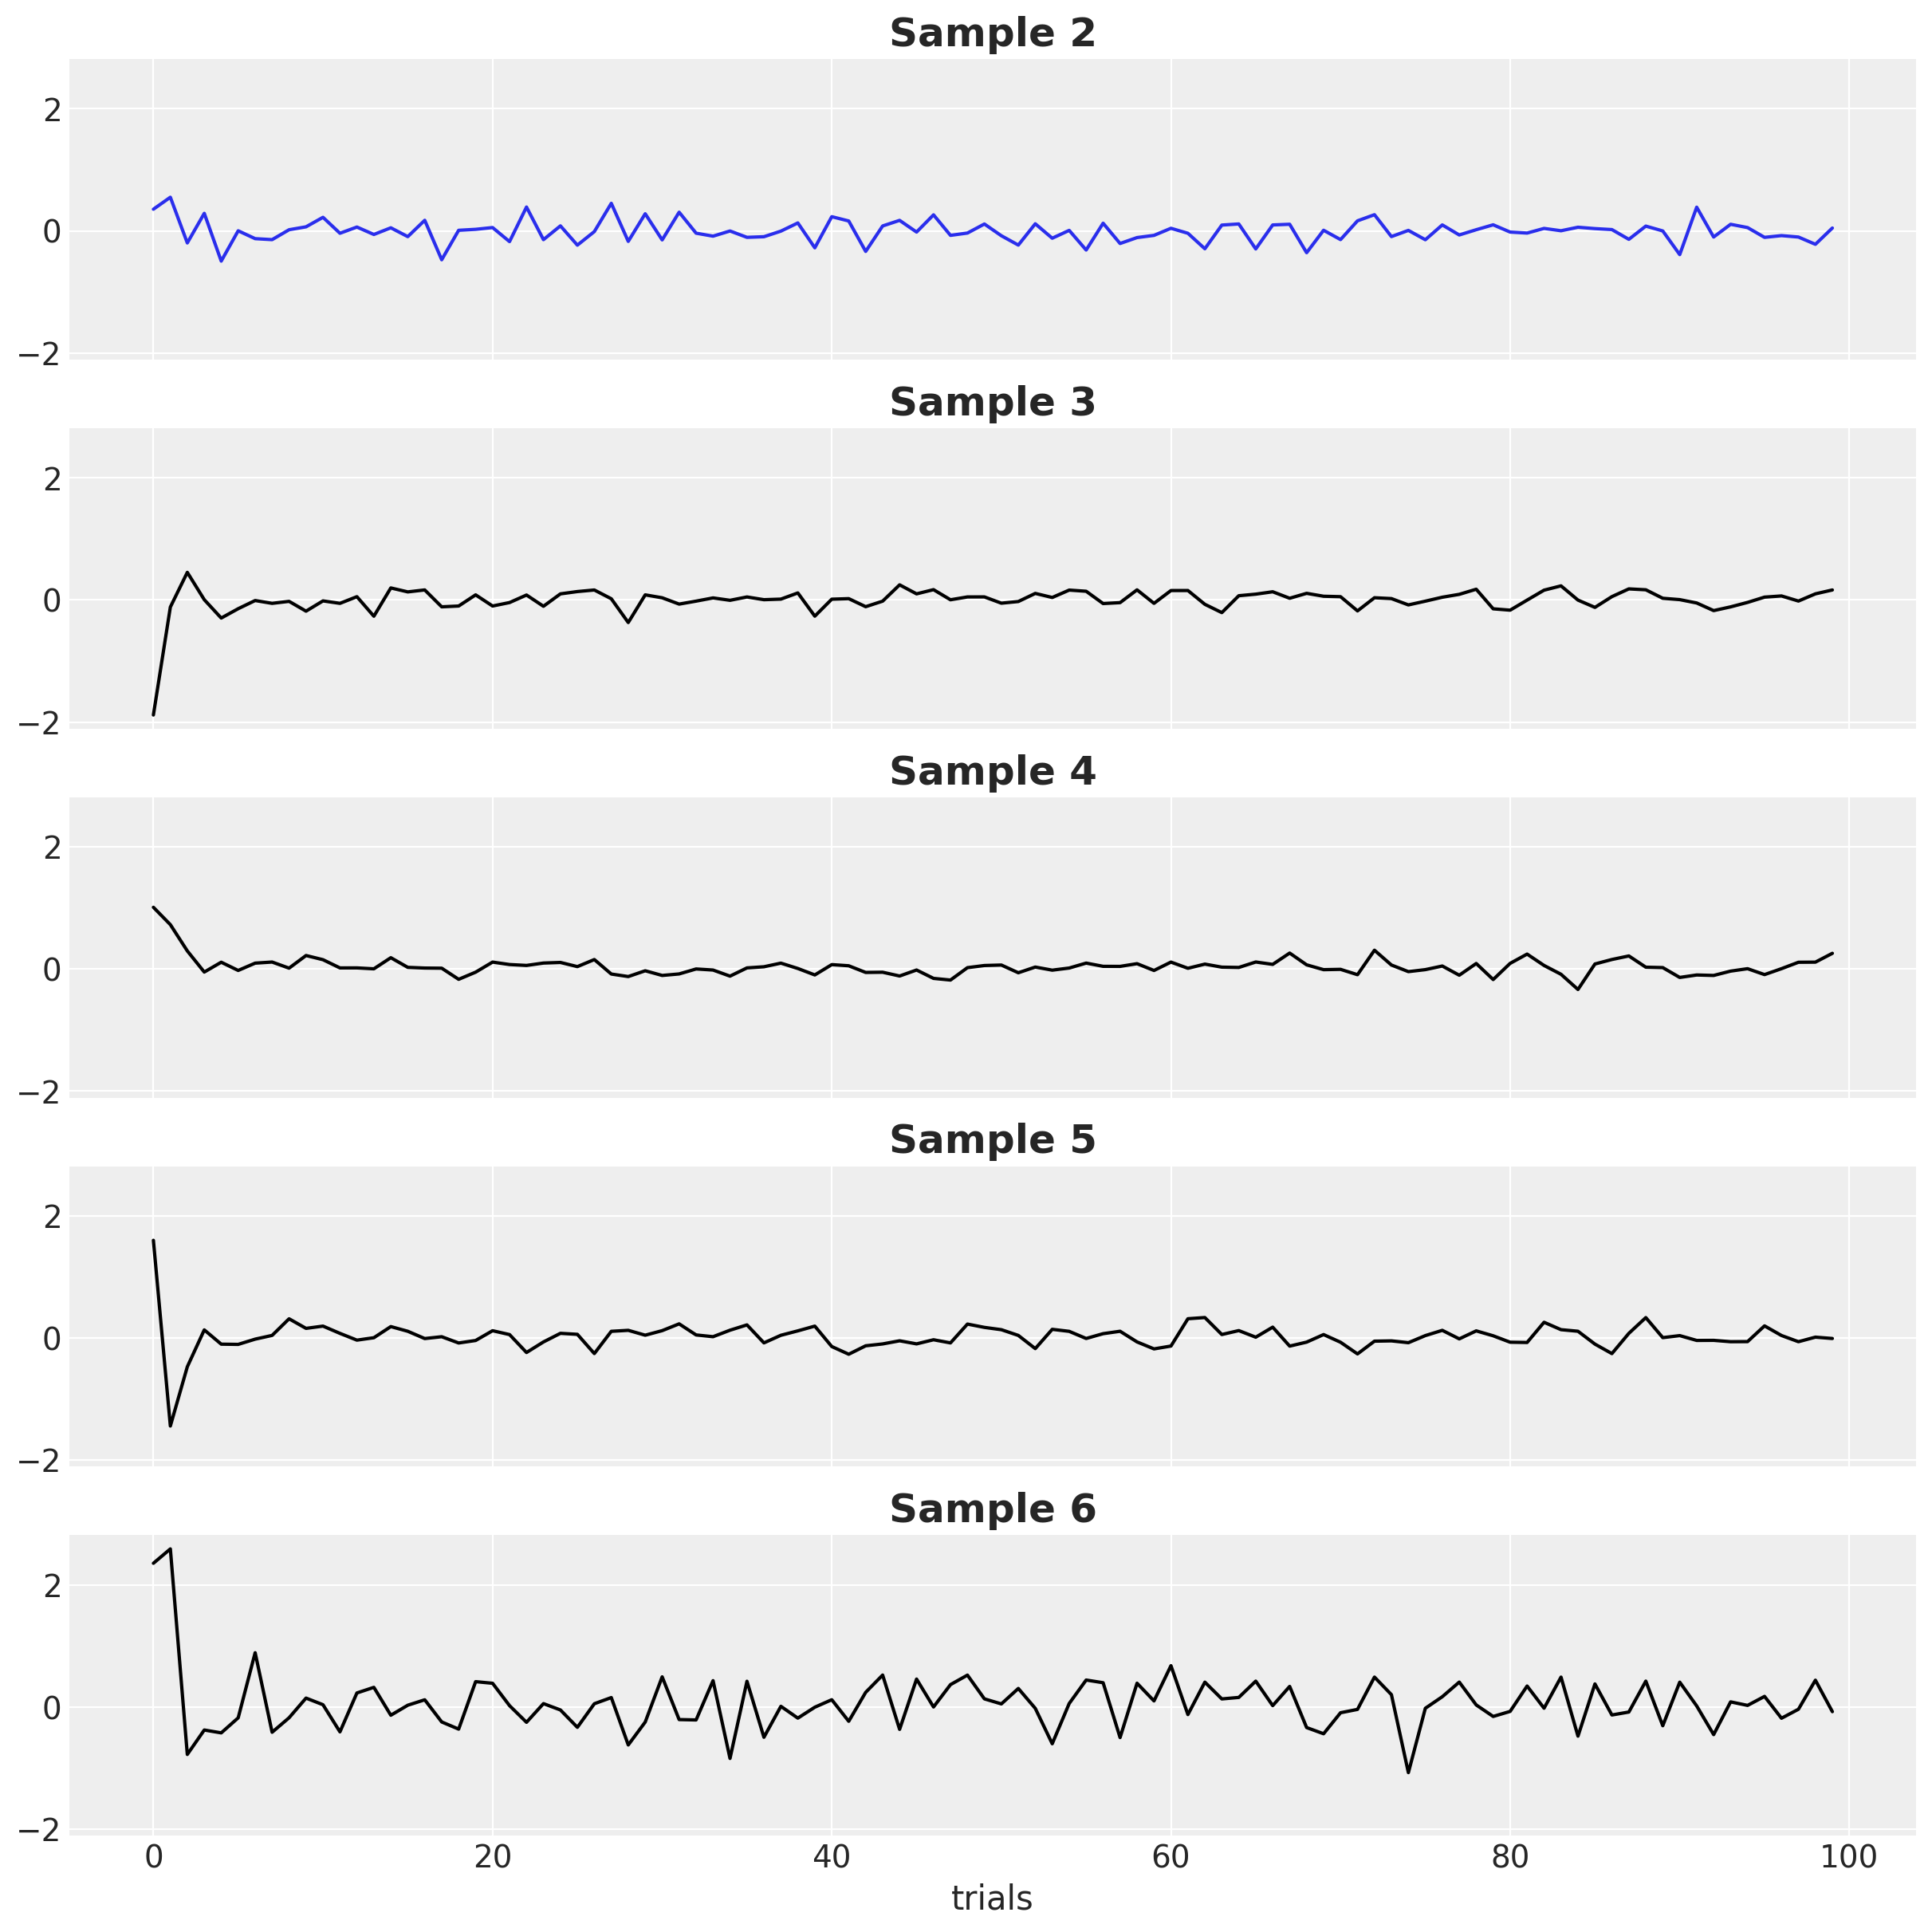

In [6]:
fig, ax = plt.subplots(
    nrows=5, ncols=1, figsize=(12, 12), sharex=True, sharey=True, layout="constrained"
)
chosen_draw = 2
for i, axi in enumerate(ax, start=chosen_draw):
    axi.plot(
        prior.prior["ar"].isel(draw=i, chain=0),
        color="C0" if i == chosen_draw else "black",
    )
    axi.set_title(f"Sample {i}", fontsize=18, fontweight="bold")
ax[-1].set_xlabel("trials")

## Posterior

In [7]:
prior_draw = prior.prior.isel(chain=0, draw=chosen_draw)

ar_init_obs.set_value(prior_draw["ar"].values[:lags])
ar_innov_obs.set_value(prior_draw["ar"].values[lags:])
ar_obs = prior_draw["ar"].to_numpy()
rho_true = prior_draw["rho"].to_numpy()
sigma_true = prior_draw["sigma"].to_numpy()

print(f"rho_true={np.round(rho_true, 3)}, {sigma_true=:.3f}")

rho_true=[-0.361 -0.052], sigma_true=0.174


In [8]:
with model:
    trace = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


Text(0.5, 0.98, 'AR(2) Model Trace')

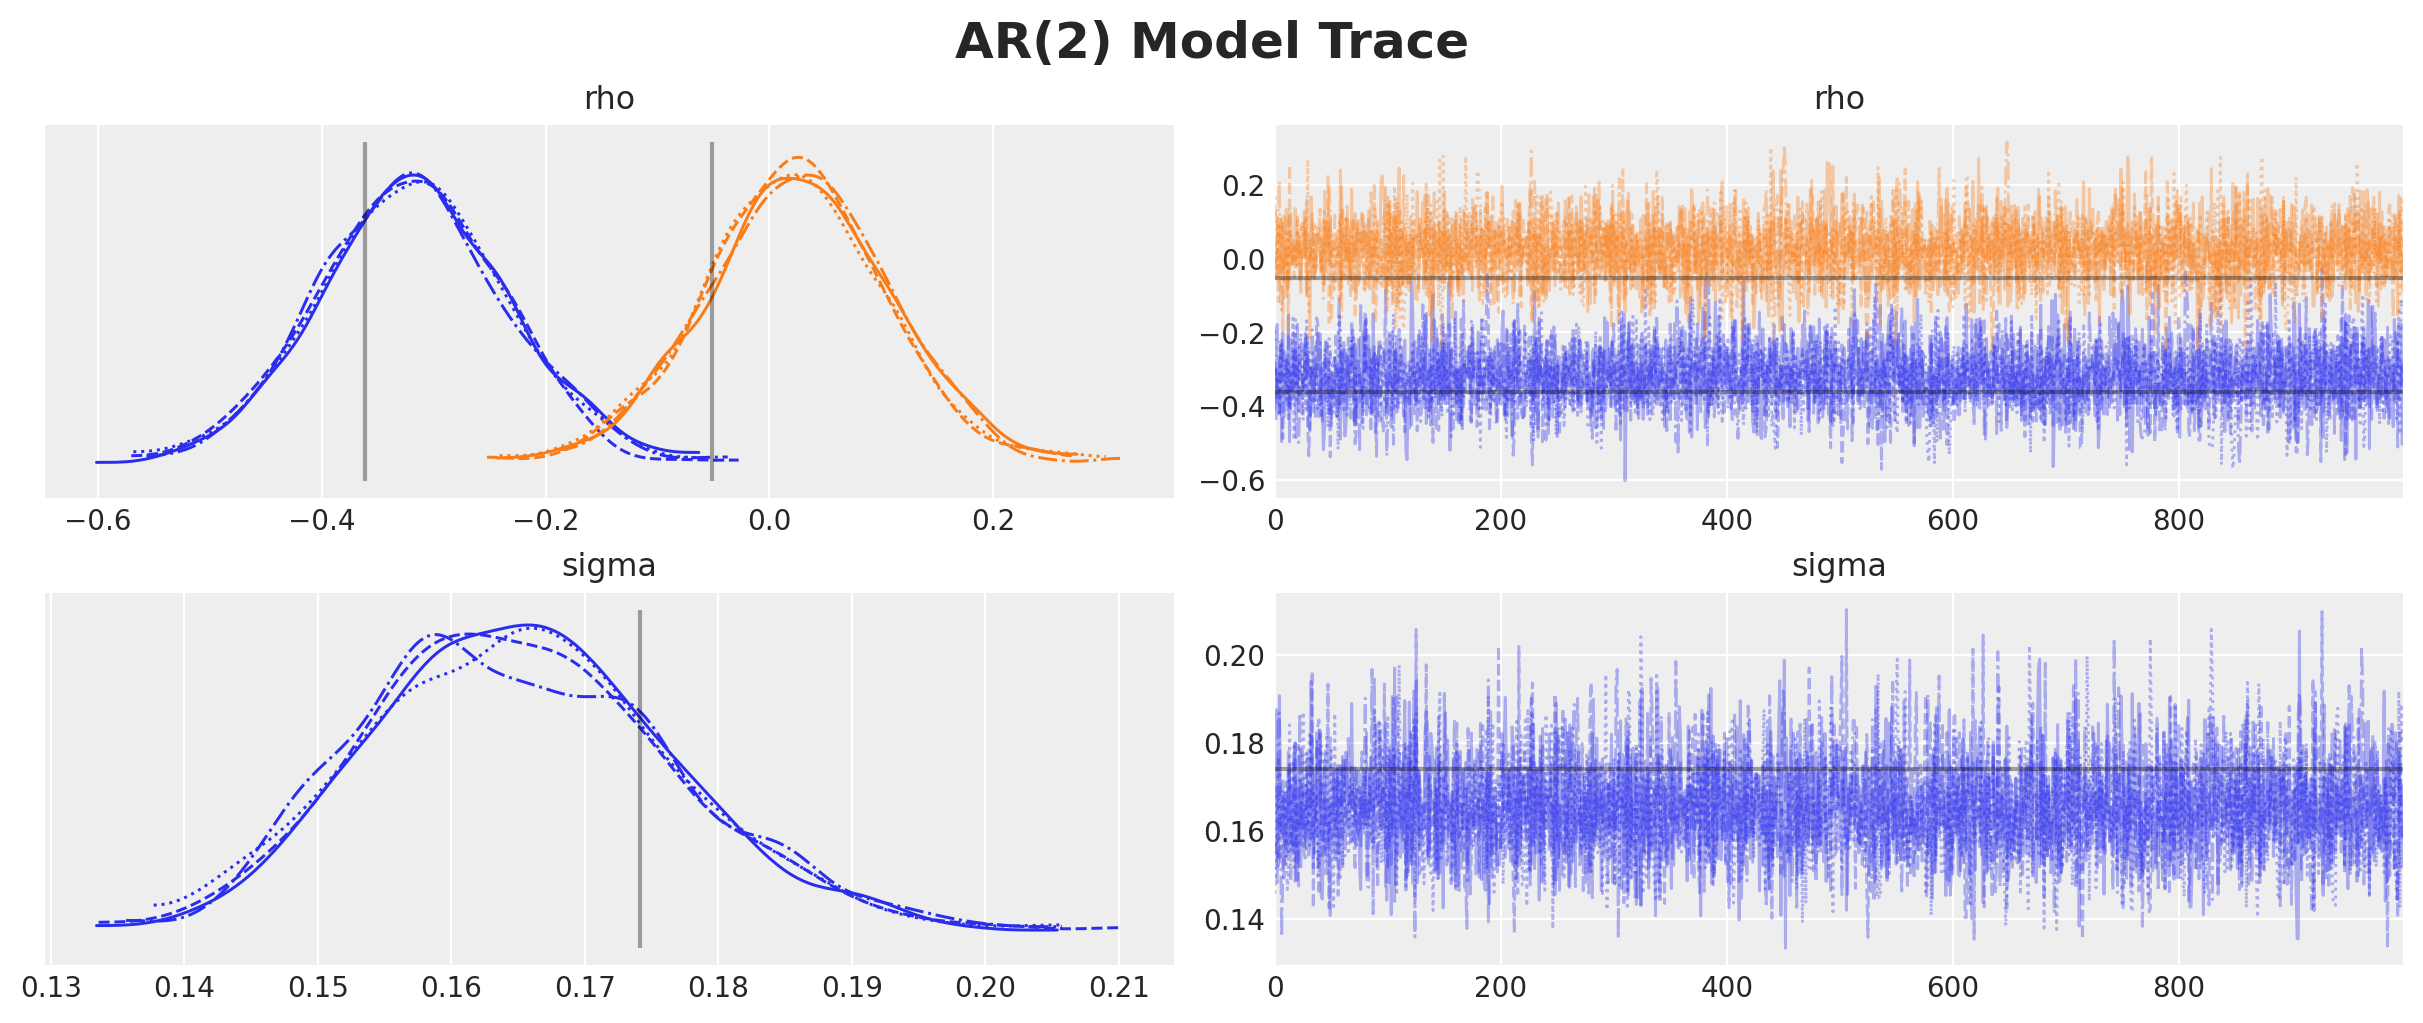

In [9]:
axes = az.plot_trace(
    data=trace,
    var_names=["rho", "sigma"],
    compact=True,
    lines=[
        ("rho", {}, rho_true),
        ("sigma", {}, sigma_true),
    ],
    backend_kwargs={"figsize": (12, 5), "layout": "constrained"},
)
plt.gcf().suptitle("AR(2) Model Trace", fontsize=18, fontweight="bold")

Text(0.5, 0.98, 'AR(2) Model Parameters Posterior')

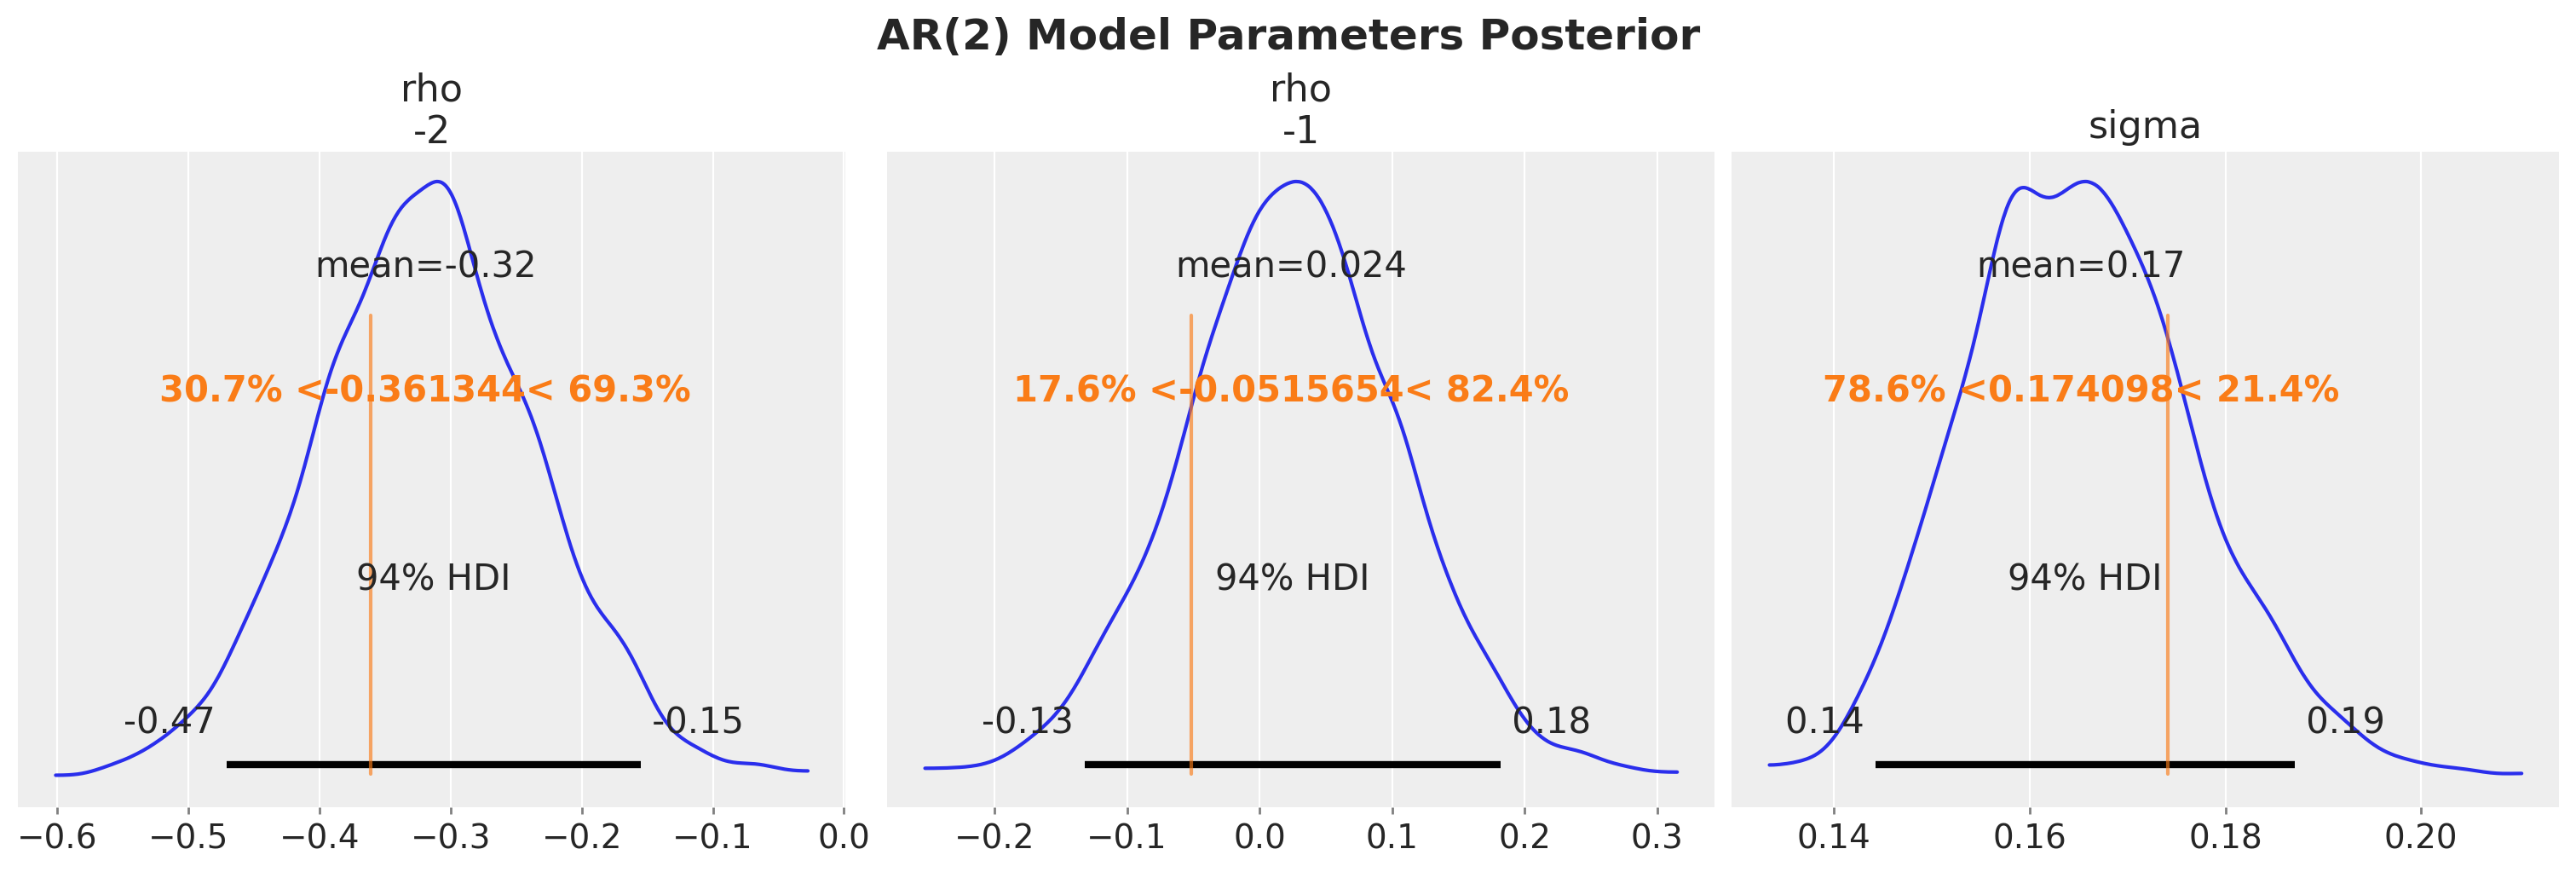

In [10]:
axes = az.plot_posterior(
    trace, var_names=["rho", "sigma"], ref_val=[*rho_true, sigma_true], figsize=(15, 5)
)
plt.gcf().suptitle("AR(2) Model Parameters Posterior", fontsize=18, fontweight="bold")

## Posterior Predictive

In [11]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, random_seed=rng)

Sampling: [ar_dist, ar_init]


Text(0.5, 1.0, 'AR(2) Posterior Predictive Samples')

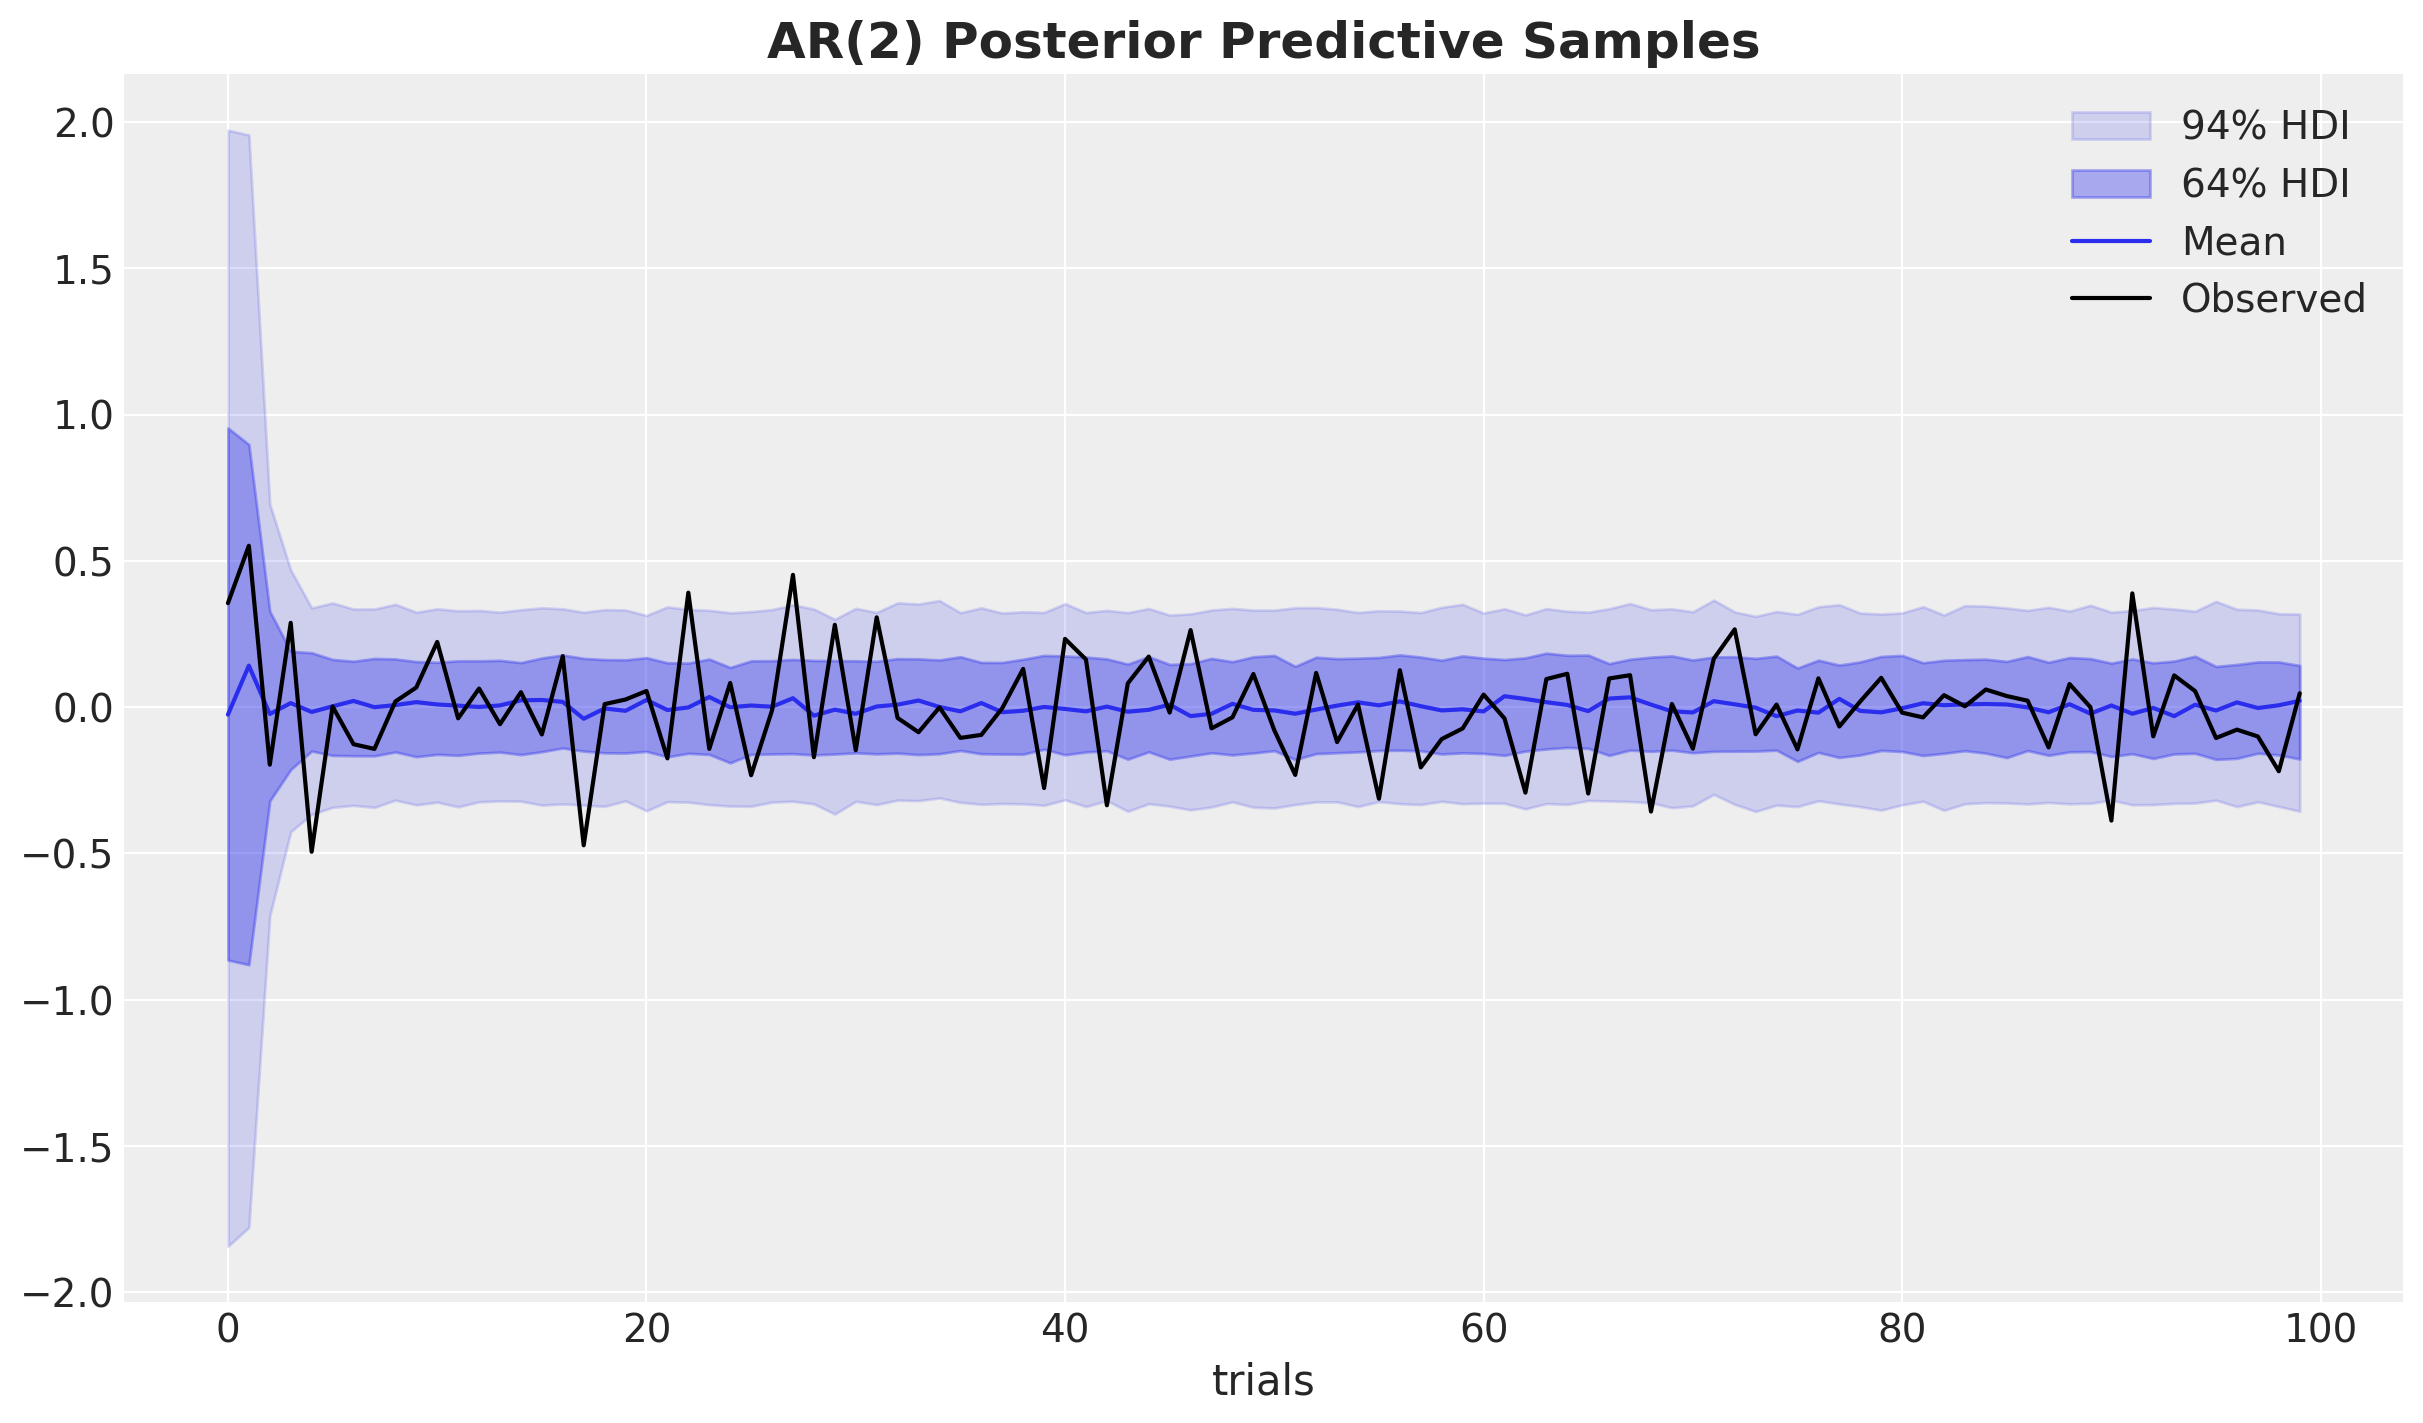

In [12]:
post_pred_ar = post_pred.posterior_predictive["ar"]

_, ax = plt.subplots()
for i, hdi_prob in enumerate((0.94, 0.64), 1):
    hdi = az.hdi(post_pred_ar, hdi_prob=hdi_prob)["ar"]
    lower = hdi.sel(hdi="lower")
    upper = hdi.sel(hdi="higher")
    ax.fill_between(
        x=np.arange(trials),
        y1=lower,
        y2=upper,
        alpha=(i - 0.2) * 0.2,
        color="C0",
        label=f"{hdi_prob:.0%} HDI",
    )
ax.plot(prior.prior["ar"].mean(("chain", "draw")), color="C0", label="Mean")
ax.plot(ar_obs, color="black", label="Observed")
ax.legend(loc="upper right")
ax.set_xlabel("trials")
ax.set_title("AR(2) Posterior Predictive Samples", fontsize=18, fontweight="bold")

Text(0.5, 1.05, 'AR(2) Posterior Predictive Samples')

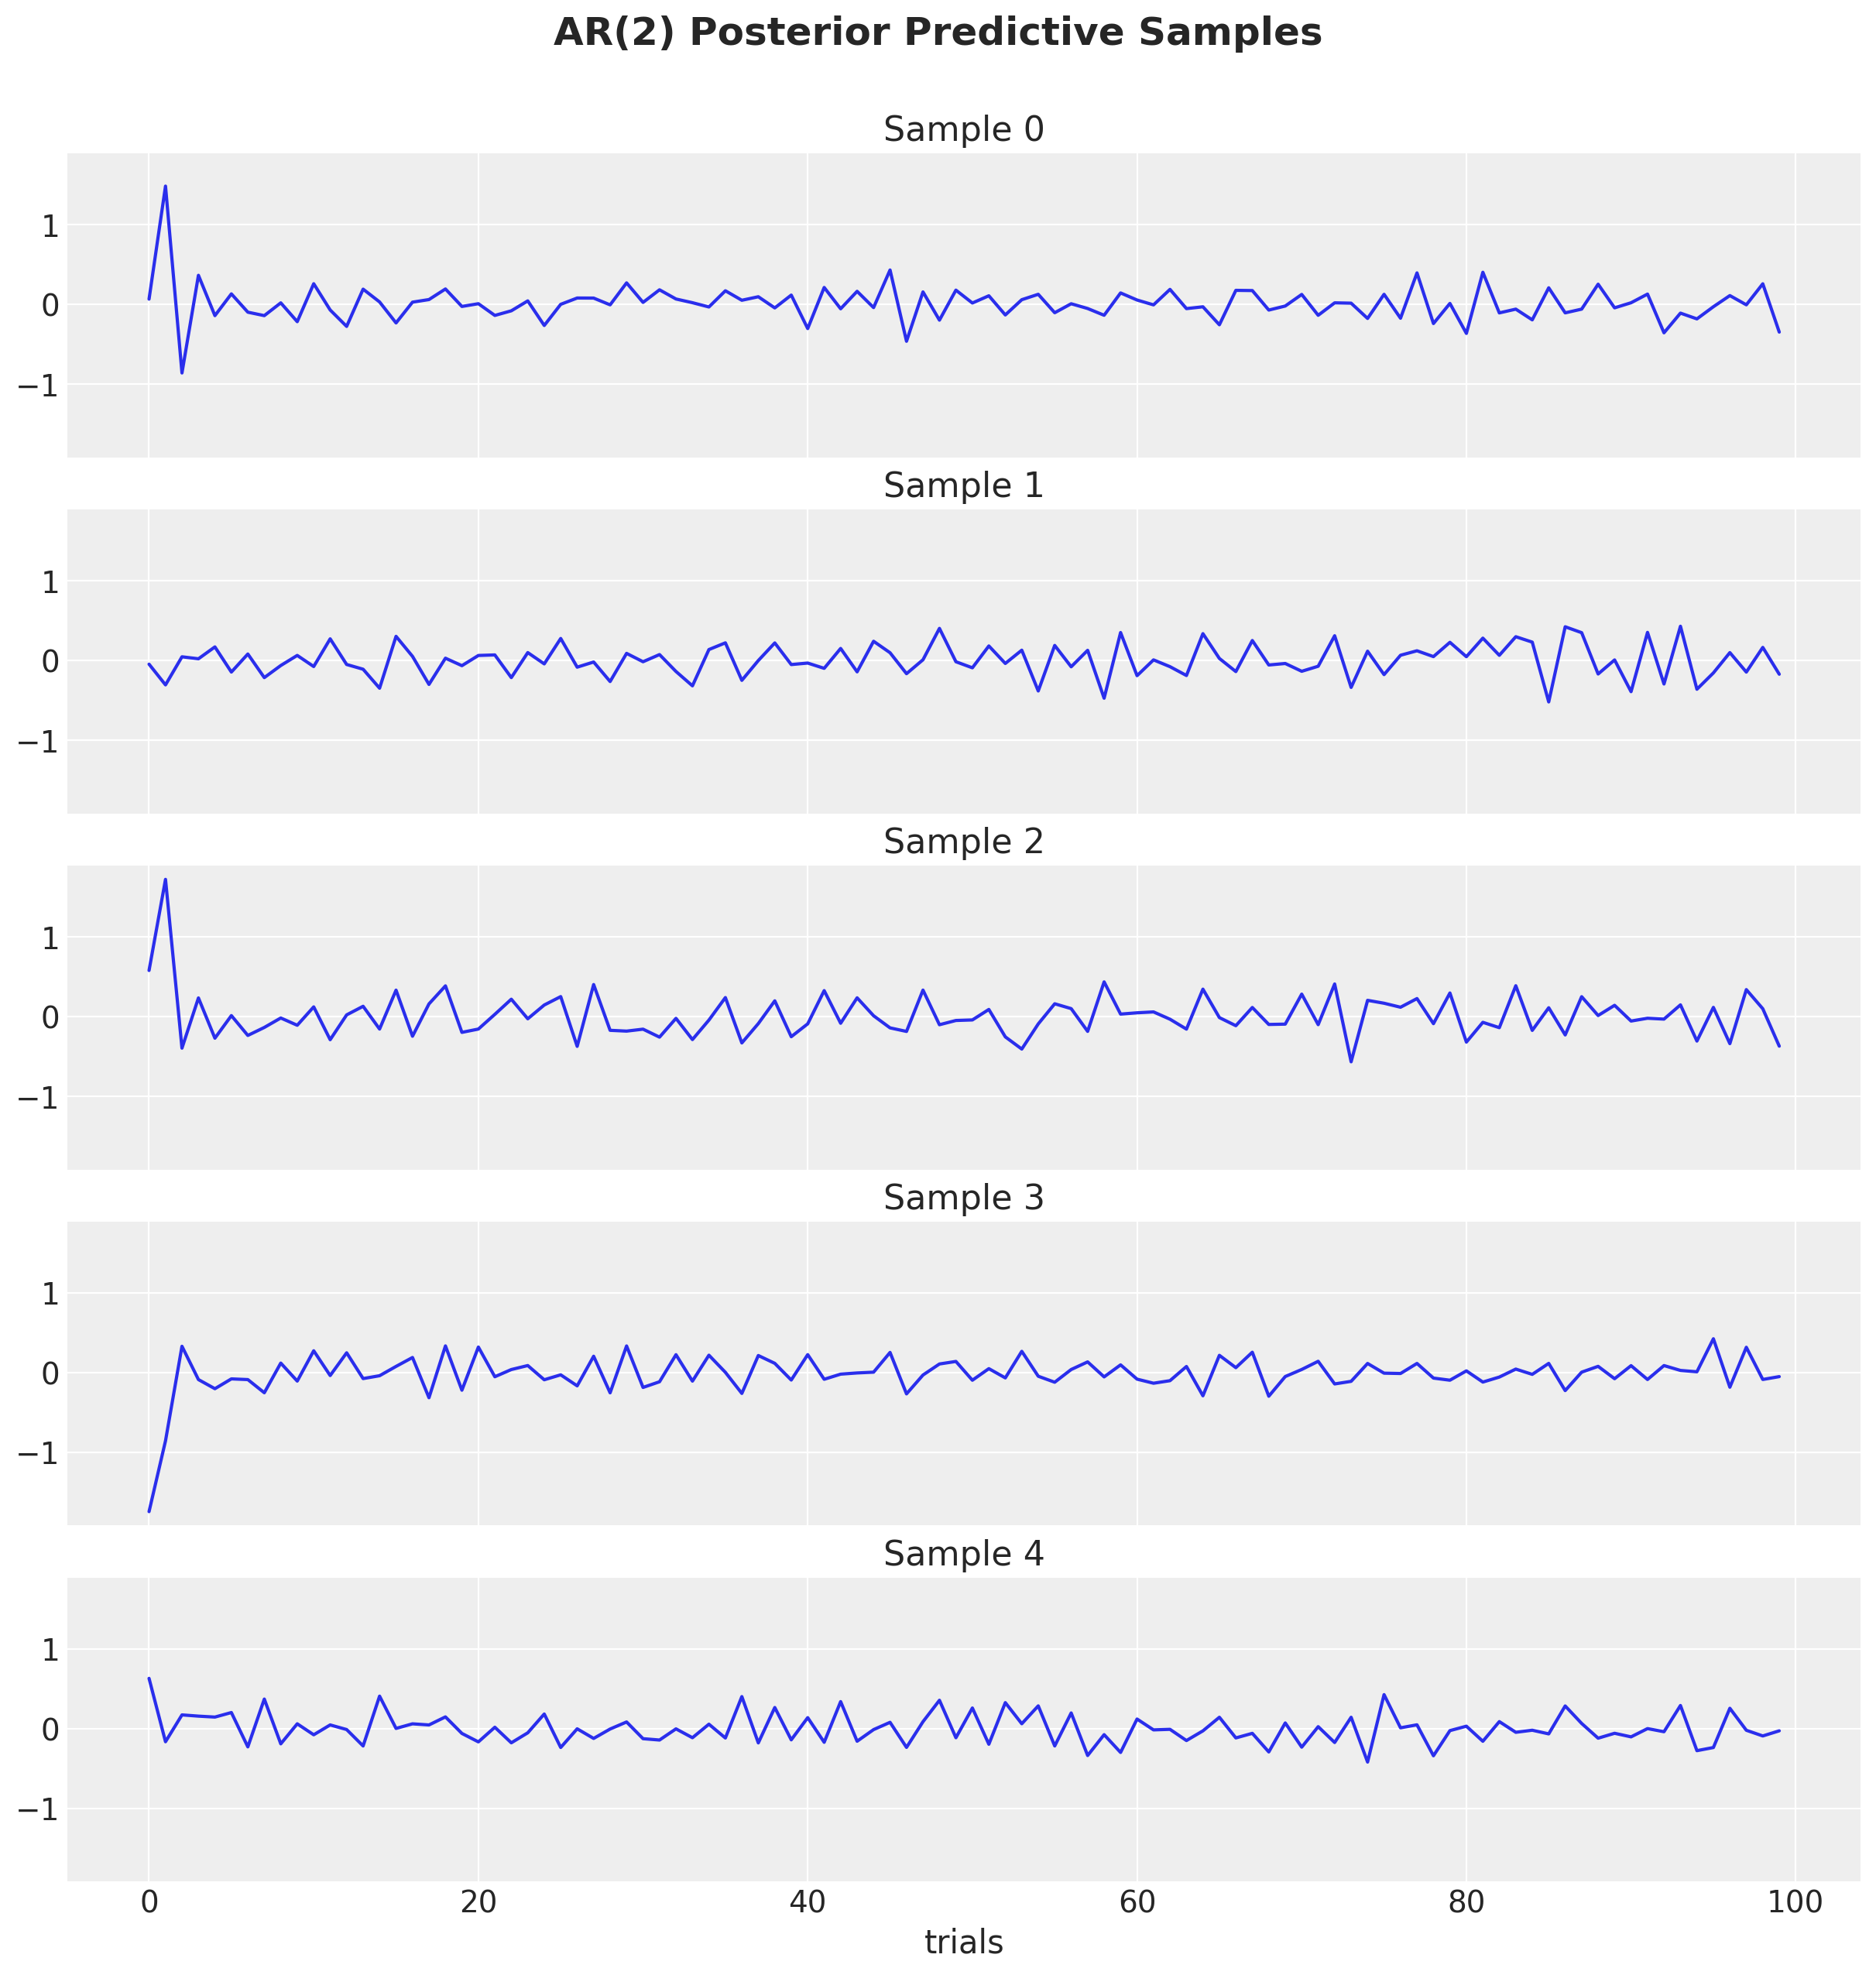

In [13]:
fig, ax = plt.subplots(
    nrows=5, ncols=1, figsize=(12, 12), sharex=True, sharey=True, layout="constrained"
)
for i, axi in enumerate(ax):
    axi.plot(post_pred.posterior_predictive["ar"].isel(draw=i, chain=0), color="C0")
    axi.set_title(f"Sample {i}")

ax[-1].set_xlabel("trials")

fig.suptitle("AR(2) Posterior Predictive Samples", fontsize=18, fontweight="bold", y=1.05)

## Authors
- Authored by [Juan Orduz](https://juanitorduz.github.io/) and [Ricardo Vieira](https://github.com/ricardoV94) in March 2024

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Wed Feb 28 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.20.0

pytensor: 2.18.6

matplotlib: 3.8.2
pytensor  : 2.18.6
pymc      : 5.10.3
arviz     : 0.17.0
numpy     : 1.26.3

Watermark: 2.4.3



:::{include} ../page_footer.md
:::